# Exploratory Project - Powerline Fault Detection for Partial Discharge using Deep Learning


In [2]:
import keras
import keras.backend as K
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
import tensorflow as tf
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sns.set_style("whitegrid")

## Basic Overview of Fault Detection problem

**Signals from VSB Dataset:**

- 800.000 measurement points for 8712 signals.
- The signals are **three-phased** so there are 2904 distinct signaling instances.

### What is partial discharge?

 - Typical situation of PD: imagine there is an internal cavity/void or **impurity in insulation**. 
 - When **High Voltage** is applied on conductor, a field is also induced on the cavity. Further, when the field increases, this **defect breaks down** and **discharges** different forms of energy which result in partial discharge.
 - This phenomenon is damaging over a long period of time. It is not event that occurs suddenly. 

### Classical Modes of Detection of Partial Discharge
- Partial Discharges can be detected by **measuring the emissions** they give off: Ultrasonic Sound, Transient Earth Voltages (TEV and UHF energy).
- **Two possible approaches with deep learning we thought of**:
    - Feature Extraction on signals and feeding them into Neural Network for classification.
    - Using Neural Network further as feature extractors and then use shallow classifiers for binary classification

### **So the problem comes down to:** Classify if the powerline is damaged(has fault) or not, based on signal characteristics of the powerline recorded through a meter.
#### Our approach to this problem is:
- Extract features from time series data for classification using a basic CNN+LSTM model.
- Use **CNN** for further feature extraction and **LSTM** to extract temporal dependencies and perform time series classification on the top layer.

## 1. Load the signal dataset

The dataset is of Apache Parquet form, the whole data(train and test) is over 10GB.

In [3]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

In [4]:
%%time 
train_set = pq.read_pandas('../input/train.parquet').to_pandas()

CPU times: user 46.2 s, sys: 21.2 s, total: 1min 7s
Wall time: 1min 46s


In [5]:
%%time
meta_train = pd.read_csv('../input/metadata_train.csv')

CPU times: user 19 ms, sys: 2.28 ms, total: 21.3 ms
Wall time: 45.8 ms


## 2. Process and Minimize Data

- Here the signal is shortened since processing of 800,000 measurements of a signal would be troublesome to compute with a LSTM. This is an important step to handle with such big data.

In [6]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    length = len(x)
    pool = np.int32(np.ceil(length/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,length, pool)):
        if i+pool < length:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [7]:
x_train = []
y_train = []
for i in tqdm(meta_train.signal_id):
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train_set.iloc[:, idx].values, n_part=400)))

100%|██████████| 8712/8712 [02:07<00:00, 68.49it/s]


In [8]:
del train_set; gc.collect()

16693

In [9]:
y_train = np.array(y_train).reshape(-1,)
X_train = np.array(x_train).reshape(-1,x_train[0].shape[0])

## 3. Build Primitive CNN + LSTM Model

* CNN is used for feature extraction and LSTM is for capturing temporal dependency of the signals.

In [10]:
#for area-under-curve metric
def keras_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [11]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


In [69]:
n_signals = 1 #Each instance is one signal.Further diversification would be made after filtering
n_outputs = 1 #Binary Classification problem

In [70]:
#Build the model of CNN+LSTM
verbose, epochs, batch_size = True, 15, 16
n_steps, n_length = 40, 10
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [71]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 8, 64)       256       
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 6, 64)       12352     
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
__________

In [15]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
8712/8712 [==============================] - 37s 4ms/step - loss: 0.2224 - keras_auc: 0.6138
Epoch 2/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1812 - keras_auc: 0.6958
Epoch 3/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1486 - keras_auc: 0.7770
Epoch 4/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1350 - keras_auc: 0.8278
Epoch 5/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1294 - keras_auc: 0.8564
Epoch 6/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1235 - keras_auc: 0.8736
Epoch 7/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1198 - keras_auc: 0.8845
Epoch 8/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1168 - keras_auc: 0.8933
Epoch 9/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1173 - keras_auc: 0.9006
Epoch 10/15
8712/8712 [==============================] - 35s 4ms

In [16]:
model.save_weights('model1.hdf5')

In [17]:
#%%time
#test_set = pq.read_pandas('../input/test.parquet').to_pandas()

In [18]:
#%%time
#meta_test = pd.read_csv('../input/metadata_test.csv')

In [19]:
#x_test = []
#for i in tqdm(meta_test.signal_id.values):
#   idx=i-8712
#    clear_output(wait=True)
#    x_test.append(abs(feature_extractor(test_set.iloc[:, idx].values, n_part=400)))

In [20]:
#del test_set; gc.collect()

In [21]:
#X_test = x_test.reshape((x_test.shape[0], n_steps, n_length, n_signals))

In [22]:
#preds = model.predict(X_test)

In [23]:
#threshpreds = (preds>0.5)*1

## 4. Processing of Signals to Diversify the Model with new features

We only fed the signals to the model and the only feature engineering was to reduce signal lengths because 800000 time steps is computationally time consuming and complicated too, with LSTM. Signal classification applications takes more than one modalities or channels in real life. So here we have tried to increase the feature size in terms of channel depth rather than feature count.

Proposed data structure: **n_instances x n_timesteps x  n_channels**

### 4.a - Filter & Transform Signals - Major use of FFT is done here

In [26]:
#Both numpy and scipy has utilities for FFT which is an endlessly useful algorithm
from numpy.fft import *
from scipy import fftpack

In [27]:
%%time 
train_set = pq.read_pandas('../input/train.parquet').to_pandas()

CPU times: user 43.9 s, sys: 18 s, total: 1min 1s
Wall time: 1min 27s


In [28]:
#FFT to filter out HF components and get main signal profile
def low_pass(s, threshold=1e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [29]:
def phase_indices(signal_num):
    phase1 = 3*signal_num
    phase2 = 3*signal_num + 1
    phase3 = 3*signal_num + 2
    return phase1,phase2,phase3

In [30]:
s_id = 14
p1,p2,p3 = phase_indices(s_id)

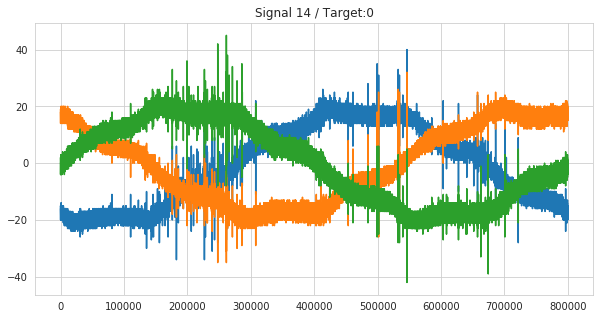

In [31]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(train_set.iloc[:,p1])
plt.plot(train_set.iloc[:,p2])
plt.plot(train_set.iloc[:,p3])

In [32]:
lf_signal_1 = low_pass(train_set.iloc[:,p1])
lf_signal_2 = low_pass(train_set.iloc[:,p2])
lf_signal_3 = low_pass(train_set.iloc[:,p3])

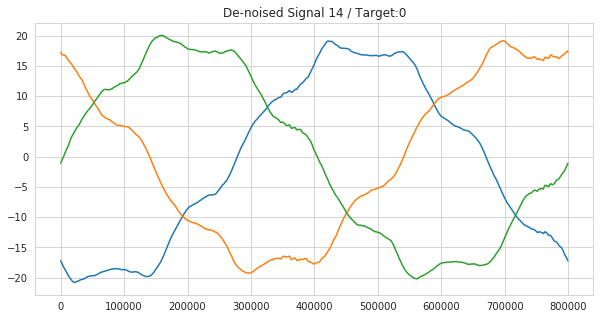

In [33]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

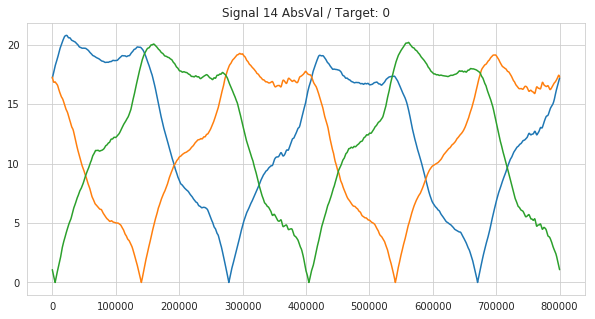

In [34]:
plt.figure(figsize=(10,5))
plt.title('Signal %d AbsVal / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(np.abs(lf_signal_1))
plt.plot(np.abs(lf_signal_2))
plt.plot(np.abs(lf_signal_3))

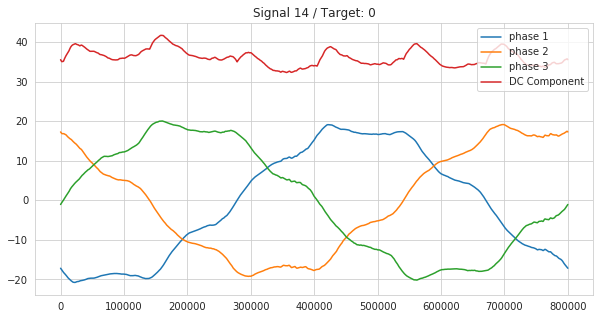

In [35]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)
plt.plot((np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)))
plt.legend(['phase 1','phase 2','phase 3','DC Component'],loc=1)

In [36]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [37]:
hf_signal_1 = high_pass(train_set.iloc[:,p1])
hf_signal_2 = high_pass(train_set.iloc[:,p2])
hf_signal_3 = high_pass(train_set.iloc[:,p3])

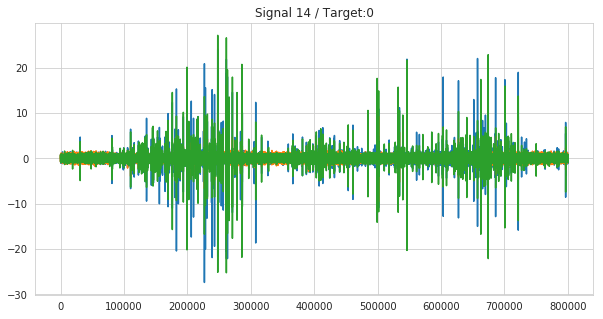

In [38]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1)
plt.plot(hf_signal_2)
plt.plot(hf_signal_3)

As seen above we can decouple the signals into their high and low frequency components using FFT. So the number of signal channels that are fed into the model can may very well be diversified using different decouplings in time and frequency domains. 

The mode of decoupling so far was filtering what we have to get new signals. Following part is about playing around the frequency domain to create features. 

### 4.b - Spectogram Features (Only Visualised- can be added as features in the future)

In [39]:
signal = train_set.iloc[:,p1]

In [40]:
%%time
x = signal
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 1.44 ms, sys: 1.1 ms, total: 2.54 ms
Wall time: 6.01 ms


/opt/conda/lib/python3.6/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


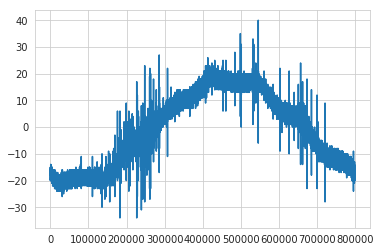

In [41]:
plt.plot(x)

<StemContainer object of 3 artists>

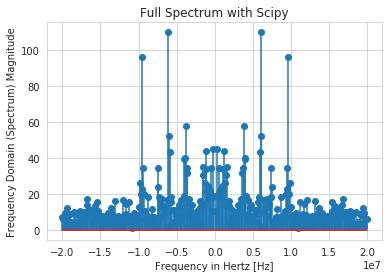

In [42]:
fig, ax = plt.subplots()
ax.set_title('Full Spectrum with Scipy')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [43]:
%%time
x = high_pass(train_set.iloc[:,p1])
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 42.1 ms, sys: 7.13 ms, total: 49.2 ms
Wall time: 47.6 ms


/opt/conda/lib/python3.6/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


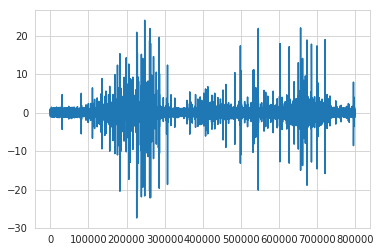

In [44]:
plt.plot(x)

<StemContainer object of 3 artists>

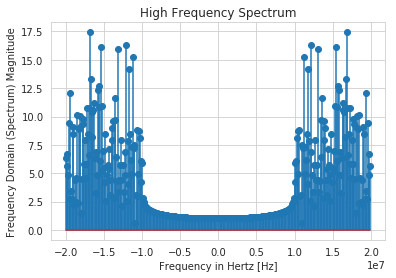

In [45]:
fig, ax = plt.subplots()
ax.set_title('High Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [46]:
%%time
x = low_pass(signal)
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 43 ms, sys: 8.29 ms, total: 51.3 ms
Wall time: 49.8 ms


/opt/conda/lib/python3.6/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


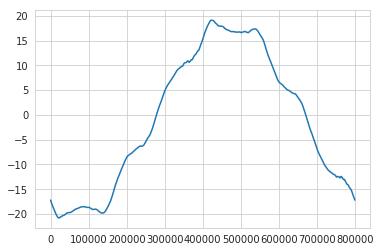

In [47]:
plt.plot(x)

<StemContainer object of 3 artists>

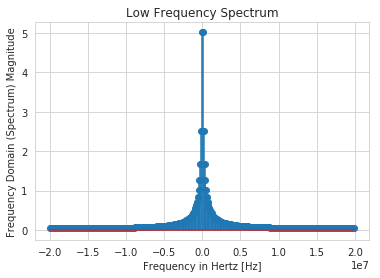

In [48]:
fig, ax = plt.subplots()
ax.set_title('Low Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

### 4.c - Frequencies vs. Time


In [49]:
p1,p2,p3 = phase_indices(100)
signal = train_set.iloc[:,p1]

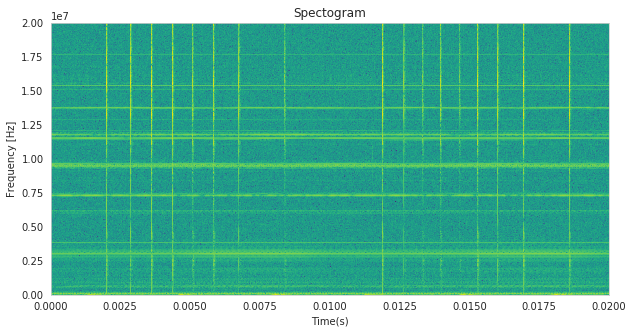

In [50]:
from scipy import signal as sgn
M = 1024
rate = 1/(2e-2/signal.size)

freqs, times, Sx = sgn.spectrogram(signal.values, fs=rate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend='constant', scaling='spectrum')

f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time(s)')
ax.set_title('Spectogram')
ax.pcolormesh(times, freqs, np.log10(Sx), cmap='viridis')

Now we have the temporal behavior of frequencies that compose our signal in terms of their magnitudes. Aggregations can be made on both time and frequency axes by selecting appropriate window sizes.

## 5. Add Features for improving the model

For initial improvement of our model we will use diversification of signals mentioned previously
- **Signal itself**
- **LF** component
- **HF** component
- **DC** component from three-phase merge)

The justification for DC component is that all three phase signals are rectified to form a DC behavior with a small amount of ripple. I naively assumed that a partial discharce occuring in any of the 3 signals, will result in corruption at the resulting voltage behavior. While composing up the features, each instance that belong to a triple will have the same "DC component."

In [51]:
x_train_lp = []
x_train_hp = []
x_train_dc = []
for i in meta_train.signal_id:
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    clear_output(wait=True)
    display(idx)
    hp = high_pass(train_set.iloc[:, idx[0]])
    lp = low_pass(train_set.iloc[:, idx[0]])
    meas_id = meta_train.id_measurement[meta_train.signal_id==idx].values[0]
    p1,p2,p3=phase_indices(meas_id)
    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(train_set.iloc[:,p1]), low_pass(train_set.iloc[:,p2]), low_pass(train_set.iloc[:,p3])
    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
    x_train_lp.append(abs(feature_extractor(lp, n_part=400)))
    x_train_hp.append(abs(feature_extractor(hp, n_part=400)))
    x_train_dc.append(abs(feature_extractor(dc, n_part=400)))

[8711]

In [52]:
del train_set; gc.collect()

16706

In [53]:
#x_test_lp = []
#x_test_hp = []
#x_test_dc = []
#for i in tqdm(meta_test.signal_id):
#    idx = idx=i-8712
#    clear_output(wait=True)
#    #display(idx)
#    hp = high_pass(test_set.iloc[:, idx])
#    lp = low_pass(test_set.iloc[:, idx])
#    meas_id = meta_test.id_measurement[meta_test.signal_id==i].values[0]
#    p1,p2,p3=phase_indices(meas_id)
#    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(test_set.iloc[:,p1-8712]), low_pass(test_set.iloc[:,p2-8712]), low_pass(test_set.iloc[:,p3-8712])
#    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
#    x_test_lp.append(abs(feature_extractor(lp, n_part=400)))
#    x_test_hp.append(abs(feature_extractor(hp, n_part=400)))
#    x_test_dc.append(abs(feature_extractor(dc, n_part=400)))

In [54]:
x_train = np.array(x_train).reshape(-1,x_train[0].shape[0])
x_train_lp = np.array(x_train).reshape(-1,x_train_lp[0].shape[0])
x_train_hp = np.array(x_train).reshape(-1,x_train_hp[0].shape[0])
x_train_dc = np.array(x_train).reshape(-1,x_train_dc[0].shape[0])

In [55]:
#x_test = np.array(x_test).reshape(-1,x_test[0].shape[0])
#x_test_lp = np.array(x_test).reshape(-1,x_test_lp[0].shape[0])
#x_test_hp = np.array(x_test).reshape(-1,x_test_hp[0].shape[0])
#x_test_dc = np.array(x_test).reshape(-1,x_test_dc[0].shape[0])

In [56]:
train = np.dstack((x_train,x_train_lp,x_train_hp,x_train_dc))
#test = np.dstack((x_test,x_test_lp,x_test_hp,x_test_dc))

In [57]:
y_train = np.array(y_train).reshape(-1,)

In [73]:
verbose, epochs, batch_size = True, 15, 16
n_signals,n_steps, n_length = 4,40, 10
train = train.reshape((train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [74]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, None, 8, 64)       832       
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 6, 64)       12352     
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
__________

In [77]:
# fit network
model.fit(train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1227 - keras_auc: 0.8886
Epoch 2/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1175 - keras_auc: 0.8927
Epoch 3/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1171 - keras_auc: 0.8965
Epoch 4/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1200 - keras_auc: 0.8992
Epoch 5/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1109 - keras_auc: 0.9024
Epoch 6/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1084 - keras_auc: 0.9055
Epoch 7/15
8712/8712 [==============================] - 34s 4ms/step - loss: 0.1080 - keras_auc: 0.9083
Epoch 8/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1056 - keras_auc: 0.9109
Epoch 9/15
8712/8712 [==============================] - 35s 4ms/step - loss: 0.1120 - keras_auc: 0.9133
Epoch 10/15
8712/8712 [==============================] - 34s 4ms

In [61]:
model.save_weights('model2.hdf5')

In [62]:
#X_test = test.reshape((test.shape[0], n_steps, n_length, n_signals))

In [63]:
#preds = model.predict(X_test)

In [64]:
#threshpreds = (preds>0.5)*1